In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import glob
from scipy.interpolate import interp1d
# from plot_funcs import *
from matplotlib import patches

In [2]:
def modecount_rebin(kk, pk, modes, minmodes=20, ndesired=200): #from MP-Gadget
    """Rebins a power spectrum so that there are sufficient modes in each bin"""
    assert np.all(kk) > 0
    logkk=np.log10(kk)
    mdlogk = (np.max(logkk) - np.min(logkk))/ndesired
    istart=iend=1
    count=0
    k_list=[kk[0]]
    pk_list=[pk[0]]
    targetlogk=mdlogk+logkk[istart]
    while iend < np.size(logkk)-1:
        count+=modes[iend]
        iend+=1
        if count >= minmodes and logkk[iend-1] >= targetlogk:
            pk1 = np.sum(modes[istart:iend]*pk[istart:iend])/count
            kk1 = np.sum(modes[istart:iend]*kk[istart:iend])/count
            k_list.append(kk1)
            pk_list.append(pk1)
            istart=iend
            targetlogk=mdlogk+logkk[istart]
            count=0
    k_list = np.array(k_list)
    pk_list = np.array(pk_list)
    return (k_list, pk_list)

def load_rebin(spec_file):
    k_raw, Pk_raw, modes = np.loadtxt(spec_file, usecols=(0,1,2), unpack=True)
    k, Pk = modecount_rebin(k_raw, Pk_raw, modes)
    return k, Pk

In [3]:
# relative difference
def rel_dif(x1, y1, x2, y2):
    # Transform x1, x2, y1, and y2 into log10 space
    log10_x1 = np.log10(x1)
    log10_x2 = np.log10(x2)
    log10_y1 = np.log10(y1)
    log10_y2 = np.log10(y2)

    # Define the common log10(x) range for interpolation
    common_log10_x_min = max(min(log10_x1), min(log10_x2))
    common_log10_x_max = min(max(log10_x1), max(log10_x2))
    common_log10_x = np.linspace(common_log10_x_min, common_log10_x_max, 100)

    # Interpolate log10_y1 and log10_y2 to the common log10_x grid
    interp_log10_y1 = interp1d(log10_x1, log10_y1, kind='linear')(common_log10_x)
    interp_log10_y2 = interp1d(log10_x2, log10_y2, kind='linear')(common_log10_x)

    # Transform interpolated log10 values back to the original space
    interp_y1 = 10**interp_log10_y1
    interp_y2 = 10**interp_log10_y2
    common_x = 10**common_log10_x  # Transform common_log10_x back to original x values

    # Compute (y2 - y1) / y1 in original space
    delta_y = (interp_y2 - interp_y1) / interp_y1
    return common_x, delta_y

In [4]:
def rMAE_av_cosmo(pred_parent, sim_parent, z, n_HF, exclude=None):
    Ps_pred, nz_ind = load_pred(pred_parent, z, n_HF)
    k_sim, Ps_sim = load_sim(sim_parent, z, nz_ind)
    k, rAEs = rel_MAEs(k_sim, Ps_sim, k_sim, Ps_pred)
    if exclude is not None:  # exclude some cosmologies
        rAEs = np.delete(rAEs, exclude, axis=0)
    rMAE_av = np.mean(rAEs, axis=0)

    rAE_av_k = np.mean(rAEs, axis=1)
    print('z=', z, rAE_av_k)
    # print('z=', z, rAEs)
    # min and max
    rMAE_min, rMAE_max = np.min(rAEs, axis=0), np.max(rAEs, axis=0)
    return k, rMAE_av, rMAE_min, rMAE_max, rAEs

# def rMAE_av_cosmo(pred_parent, sim_parent, z, n_HF):
#     Ps_pred, nz_ind = load_pred(pred_parent, z, n_HF)
#     k_sim, Ps_sim = load_sim(sim_parent, z, nz_ind)
#     k, rAEs = rel_MAEs(k_sim, Ps_sim, k_sim, Ps_pred)
#     rMAE_av = np.mean(rAEs, axis=0)

#     rAE_av_k = np.mean(rAEs, axis=1)
#     print('z=', z, rAE_av_k)
#     # print('z=', z, rAEs)
#     # min and max
#     rMAE_min, rMAE_max = np.min(rAEs, axis=0), np.max(rAEs, axis=0)
#     return k, rMAE_av, rMAE_min, rMAE_max, rAEs

def load_pred(pred_parent, z, n_HF):
    Ps_pred = []
    nz_ind = []  # for matching sim spectra
    for i in range(n_HF):
        file_path = os.path.join(pred_parent, "matter_pow_z%s_l%d.txt" % (z, i))
        if os.path.exists(file_path):
            # print(f"The file {file_path} exists.")
            data = np.loadtxt(file_path,)
            data = data.transpose()
            P_pred = data[-1]
            Ps_pred.append(P_pred)
            nz_ind.append(i)
        else:
            print(f"The file {file_path} does not exist.")
            continue
    Ps_pred = np.array(Ps_pred)
    return Ps_pred, nz_ind

def load_sim(sim_parent, z, nz_ind):
    file_path = os.path.join(sim_parent, 'matter_power_1128_Box1000_Part750_36_Box1000_Part3000_z%s/train_output_fidelity_1.txt' % z)
    k_path = os.path.join(sim_parent, 'matter_power_1128_Box1000_Part750_36_Box1000_Part3000_z%s/kf.txt' % z)
    lg_Ps = np.loadtxt(file_path)
    lg_Ps = lg_Ps[nz_ind]
    Ps_sim = 10**lg_Ps
    lg_k = np.loadtxt(k_path, usecols=(0))
    k_sim = 10**lg_k
    return k_sim, Ps_sim


def rel_MAEs(x1, y1, x2, y2):
    # Transform x1, x2, y1, and y2 into log10 space
    log10_x1 = np.log10(x1)
    log10_x2 = np.log10(x2)
    log10_y1 = np.log10(y1)
    log10_y2 = np.log10(y2)

    # Define the common log10(x) range for interpolation
    common_log10_x_min = max(min(log10_x1), min(log10_x2))
    common_log10_x_max = min(max(log10_x1), max(log10_x2))
    common_log10_x = np.linspace(common_log10_x_min, common_log10_x_max, 100)

    # Interpolate log10_y1 and log10_y2 to the common log10_x grid
    interp_log10_y1 = interp1d(log10_x1, log10_y1, kind='linear')(common_log10_x)
    interp_log10_y2 = interp1d(log10_x2, log10_y2, kind='linear')(common_log10_x)

    # Transform interpolated log10 values back to the original space
    interp_y1 = 10**interp_log10_y1
    interp_y2 = 10**interp_log10_y2
    common_x = 10**common_log10_x  # Transform common_log10_x back to original x values

    # Compute (y2 - y1) / y1 in original space
    rMAE_y = np.abs((interp_y2 / interp_y1) - 1)
    return common_x, rMAE_y

z= 0 [0.01261507 0.01923244 0.03461167 0.01642174 0.01968124 0.13402562
 0.01458555 0.00761554 0.05479084 0.01702639 0.05800556 0.03762467
 0.04105527 0.02887027 0.05312344 0.01365602 0.01725479 0.01368666
 0.05283355 0.03020511 0.01596937]
z= 0.2 [0.02161973 0.02228105 0.02868982 0.0294862  0.02912084 0.14279739
 0.00745407 0.02146875 0.05814923 0.0194603  0.03352342 0.02673902
 0.02790702 0.02842411 0.19253444 0.038063   0.02983974 0.00896735
 0.04778282 0.02382035 0.01233887]
z= 0.5 [0.010998   0.01295325 0.01773363 0.02355115 0.02225343 0.09964608
 0.00353437 0.00899306 0.04147714 0.01542314 0.03729347 0.01482893
 0.02211201 0.0142298  0.05266894 0.0486143  0.01623917 0.00878639
 0.05335928 0.02417409 0.01142136]
z= 1 [0.01045834 0.0071928  0.01202243 0.02385371 0.01935719 0.111682
 0.00540071 0.00821476 0.02947215 0.01377881 0.04800636 0.00999804
 0.03550132 0.02260152 0.04980887 0.04424586 0.00944381 0.00892125
 0.045026   0.01984033 0.00833663]
z= 2 [0.00854029 0.00906052 0.0123

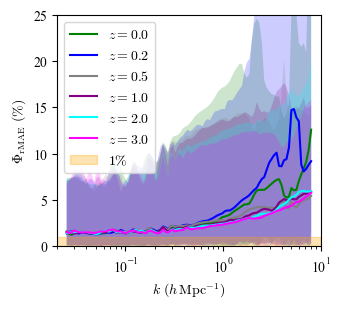

In [8]:
# relative
# sim_parent = "/work2/01317/yyang440/frontera/cosmo_11p_sims/data_for_emu" # frontera
sim_parent = "../data/combined" 
pred_parent = './loo_combined_upper/'

n_H_W = 21

fig, ax = plt.subplots(figsize=(3.4,3.))
plt.rcParams['font.family'] = 'Times New Roman'

# Set math font style
plt.rcParams['mathtext.fontset'] = 'cm'

zs = np.array([0,0.2, 0.5, 1, 2, 3, 4, 9, 49, 99])
zs_str = ['0', '0.2', '0.5', '1', '2', '3', '4', '9', '49', '99']
a = 1/(1+zs)

color_list = ['green', 'blue', 'grey', 'purple', 'cyan', 'magenta']

# ax.plot([], [], color='black', label='HF')
# # ax.plot([], [], color='black', linestyle=':', label='L1')
# ax.plot([], [], color='black', linestyle='--', label='Linear')
rMAE_zs = []

for i, scale in enumerate(a):
    if i==6:  # redshifts
        break
    c = color_list[i]
    # k_L1, Pk_L1 = load_rebin(os.path.join(sim_L1, "output/powerspectrum-%.4f.txt" % scale))
    # k_L2, Pk_L2 = load_rebin(os.path.join(sim_L2, "output/powerspectrum-%.4f.txt" % scale))
    k, rMAE, rMAE_min, rMAE_max, rAEs = rMAE_av_cosmo(pred_parent, sim_parent, zs_str[i], n_H_W)
    rMAE_zs.append(rMAE.mean())
    # k_HF, Pk_HF = load_rebin(os.path.join(sim_HF, "output/powerspectrum-%.4f.txt" % scale))
    # k_li, Pk_li = np.loadtxt(os.path.join(sim_HF, "camb_linear/ics_matterpow_%s.dat" % zs_str[i]), usecols=(0,1), unpack=True)

    ax.plot(k, rMAE/1e-2, color=c, label=r"$z=%.1f$" % zs[i])
    # ax.plot(k_li, Pk_li, '--', color=c)
    # individual
    # for rAE in rAEs:
    #     ax.plot(k, rAE/1e-2, color=c, alpha=0.4)

    ax.fill_between(k, rMAE_min/1e-2, rMAE_max/1e-2, facecolor=c, alpha=0.2, edgecolor='none')
    
rMAE_zs = np.array(rMAE_zs)
rMAE_zs_mean = rMAE_zs.mean()
print('average over k and z:', rMAE_zs_mean)
    # plt.loglog(k_HF, Pk_HF, color=c, label=r"$z=%.1f$" % zs[i])
    

    # if labels is not None:

# ax.set_ylim(.07,.5e5)
# ax.legend(loc='best')
# ax.set_yscale('log')
ax.set_ylabel(r'$\Phi_{\mathrm{rMAE}}\ (\%)$')
# plt.xlabel(r'$k\ (h\,\mathrm{Mpc}^{-1})$')
# plt.ylabel(r'$P(k)\ (h^{-3}\mathrm{Mpc}^3)$')
# ax.plot([], [], color='black', label='HF')
# ax.plot([], [], color='black', label='HF w.r.t. Linear')
# ax.plot([], [], color='black', linestyle='--', label='L2 w.r.t. HF')
ax.set_ylim(0., 25)
ax.set_xscale('log')
ax.set_xlabel(r'$k\ (h\,\mathrm{Mpc}^{-1})$')
# ax.set_ylabel(r'$(P_\mathrm{HF}-P_\mathrm{Li})/P_\mathrm{Li}$')

xlim1 = .02
xlim2 = 10
ax.set_xlim(xlim1, xlim2)

square = patches.Rectangle((xlim1, -0.0), xlim2-xlim1, 1, color='orange', alpha=.3, zorder=2, label=r'$1\%$')  # alpha ranges from 0 (transparent) to 1 (opaque)
# square1 = patches.Rectangle((xlim1, -0.01), xlim2-xlim1, 0.02, color='blue', alpha=.3, zorder=2, label=r'$1\%$')  # alpha ranges from 0 (transparent) to 1 (opaque)

# Add the square to the axes
ax.add_patch(square)
# ax.add_patch(square1)
ax.legend(loc='upper left')
# ax.set_yticks([-0.2,-.1,0,.1,.2])]\

# plt.xlim([0.005, 100])
# plt.ylim([.01,4e5])
# plt.ylim([-.3, .3])
plt.show()
# plt.savefig('matter_pow_nonl_linear_ratio.pdf', bbox_inches='tight')

z= 0 [0.01261507 0.01923244 0.03461167 0.01642174 0.01968124 0.01458555
 0.00761554 0.05479084 0.01702639 0.05800556 0.03762467 0.04105527
 0.02887027 0.01365602 0.01725479 0.01368666 0.05283355 0.03020511
 0.01596937]
z= 0.2 [0.02161973 0.02228105 0.02868982 0.0294862  0.02912084 0.00745407
 0.02146875 0.05814923 0.0194603  0.03352342 0.02673902 0.02790702
 0.02842411 0.038063   0.02983974 0.00896735 0.04778282 0.02382035
 0.01233887]
z= 0.5 [0.010998   0.01295325 0.01773363 0.02355115 0.02225343 0.00353437
 0.00899306 0.04147714 0.01542314 0.03729347 0.01482893 0.02211201
 0.0142298  0.0486143  0.01623917 0.00878639 0.05335928 0.02417409
 0.01142136]
z= 1 [0.01045834 0.0071928  0.01202243 0.02385371 0.01935719 0.00540071
 0.00821476 0.02947215 0.01377881 0.04800636 0.00999804 0.03550132
 0.02260152 0.04424586 0.00944381 0.00892125 0.045026   0.01984033
 0.00833663]
z= 2 [0.00854029 0.00906052 0.0123716  0.02316265 0.02184079 0.00492309
 0.00632203 0.04088757 0.01208244 0.04650047 0.0

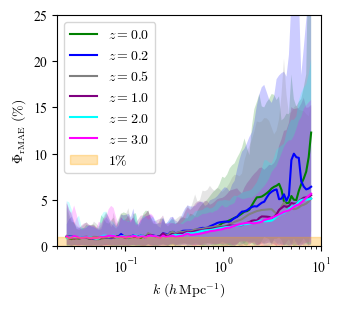

In [10]:
# relative
# sim_parent = "/work2/01317/yyang440/frontera/cosmo_11p_sims/data_for_emu" # frontera
sim_parent = "../data/combined" 
pred_parent = './loo_combined_upper/'

n_H_W = 21

fig, ax = plt.subplots(figsize=(3.4,3.))
plt.rcParams['font.family'] = 'Times New Roman'

# Set math font style
plt.rcParams['mathtext.fontset'] = 'cm'

zs = np.array([0,0.2, 0.5, 1, 2, 3, 4, 9, 49, 99])
zs_str = ['0', '0.2', '0.5', '1', '2', '3', '4', '9', '49', '99']
a = 1/(1+zs)

color_list = ['green', 'blue', 'grey', 'purple', 'cyan', 'magenta']

# ax.plot([], [], color='black', label='HF')
# # ax.plot([], [], color='black', linestyle=':', label='L1')
# ax.plot([], [], color='black', linestyle='--', label='Linear')
rMAE_zs = []

for i, scale in enumerate(a):
    if i==6:  # redshifts
        break
    c = color_list[i]
    # k_L1, Pk_L1 = load_rebin(os.path.join(sim_L1, "output/powerspectrum-%.4f.txt" % scale))
    # k_L2, Pk_L2 = load_rebin(os.path.join(sim_L2, "output/powerspectrum-%.4f.txt" % scale))
    k, rMAE, rMAE_min, rMAE_max, rAEs = rMAE_av_cosmo(pred_parent, sim_parent, zs_str[i], n_H_W, exclude=[5,14])
    rMAE_zs.append(rMAE.mean())
    # k_HF, Pk_HF = load_rebin(os.path.join(sim_HF, "output/powerspectrum-%.4f.txt" % scale))
    # k_li, Pk_li = np.loadtxt(os.path.join(sim_HF, "camb_linear/ics_matterpow_%s.dat" % zs_str[i]), usecols=(0,1), unpack=True)

    ax.plot(k, rMAE/1e-2, color=c, label=r"$z=%.1f$" % zs[i])
    # ax.plot(k_li, Pk_li, '--', color=c)
    # individual
    # for rAE in rAEs:
    #     ax.plot(k, rAE/1e-2, color=c, alpha=0.4)

    ax.fill_between(k, rMAE_min/1e-2, rMAE_max/1e-2, facecolor=c, alpha=0.2, edgecolor='none')
    
rMAE_zs = np.array(rMAE_zs)
rMAE_zs_mean = rMAE_zs.mean()
print('average over k and z:', rMAE_zs_mean)
    # plt.loglog(k_HF, Pk_HF, color=c, label=r"$z=%.1f$" % zs[i])
    

    # if labels is not None:

# ax.set_ylim(.07,.5e5)
# ax.legend(loc='best')
# ax.set_yscale('log')
ax.set_ylabel(r'$\Phi_{\mathrm{rMAE}}\ (\%)$')
# plt.xlabel(r'$k\ (h\,\mathrm{Mpc}^{-1})$')
# plt.ylabel(r'$P(k)\ (h^{-3}\mathrm{Mpc}^3)$')
# ax.plot([], [], color='black', label='HF')
# ax.plot([], [], color='black', label='HF w.r.t. Linear')
# ax.plot([], [], color='black', linestyle='--', label='L2 w.r.t. HF')
ax.set_ylim(0., 25)
ax.set_xscale('log')
ax.set_xlabel(r'$k\ (h\,\mathrm{Mpc}^{-1})$')
# ax.set_ylabel(r'$(P_\mathrm{HF}-P_\mathrm{Li})/P_\mathrm{Li}$')

xlim1 = .02
xlim2 = 10
ax.set_xlim(xlim1, xlim2)

square = patches.Rectangle((xlim1, -0.0), xlim2-xlim1, 1, color='orange', alpha=.3, zorder=2, label=r'$1\%$')  # alpha ranges from 0 (transparent) to 1 (opaque)
# square1 = patches.Rectangle((xlim1, -0.01), xlim2-xlim1, 0.02, color='blue', alpha=.3, zorder=2, label=r'$1\%$')  # alpha ranges from 0 (transparent) to 1 (opaque)

# Add the square to the axes
ax.add_patch(square)
# ax.add_patch(square1)
ax.legend(loc='upper left')
# ax.set_yticks([-0.2,-.1,0,.1,.2])

# plt.xlim([0.005, 100])
# plt.ylim([.01,4e5])
# plt.ylim([-.3, .3])
plt.show()
# plt.savefig('matter_pow_nonl_linear_ratio.pdf', bbox_inches='tight')

z= 0 [0.00133232 0.00956076 0.00193533 0.00351521 0.00268064 0.00929003
 0.00125931 0.00190786 0.00369679 0.00159293 0.00283161 0.00450585
 0.00182677 0.00313735 0.0056665 ]
z= 0.2 [0.00122335 0.00212365 0.00108641 0.00098447 0.00237488 0.00304169
 0.00090899 0.00088819 0.00115356 0.00115369 0.00075825 0.00310936
 0.0011401  0.00146272 0.00178988]
z= 0.5 [0.00056826 0.00113659 0.00076833 0.00075348 0.00200699 0.00266308
 0.0010284  0.00075419 0.0019951  0.0011838  0.00101515 0.00122551
 0.00049551 0.00187222 0.00081912]
z= 1 [0.00067405 0.00108974 0.00063166 0.00061331 0.00278367 0.00141259
 0.00100468 0.00069285 0.00170678 0.00074426 0.001109   0.00126754
 0.00088347 0.00146719 0.00076419]
z= 2 [0.00061812 0.00110446 0.00068132 0.00099002 0.00285997 0.00267141
 0.00117745 0.00040317 0.00150048 0.00119171 0.00088105 0.00142282
 0.00087022 0.00163236 0.00045576]
z= 3 [0.00052554 0.00110164 0.00046636 0.00070294 0.0026347  0.00198564
 0.00128312 0.00051638 0.00113036 0.00115211 0.0008219

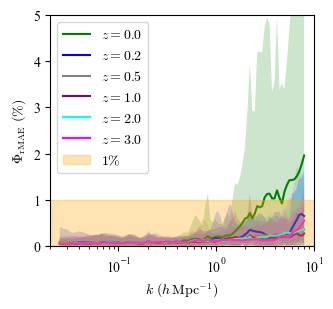

In [12]:
# narrow
sim_parent = "../data/combined" 
pred_parent = './loo_combined_upper/'

n_H_W = 21
n_H_N = 15

fig, ax = plt.subplots(figsize=(3.4,3.))
plt.rcParams['font.family'] = 'Times New Roman'

# Set math font style
plt.rcParams['mathtext.fontset'] = 'cm'

zs = np.array([0,0.2, 0.5, 1, 2, 3, 4, 9, 49, 99])
zs_str = ['0', '0.2', '0.5', '1', '2', '3', '4', '9', '49', '99']
a = 1/(1+zs)

color_list = ['green', 'blue', 'grey', 'purple', 'cyan', 'magenta']

# ax.plot([], [], color='black', label='HF')
# # ax.plot([], [], color='black', linestyle=':', label='L1')
# ax.plot([], [], color='black', linestyle='--', label='Linear')
rMAE_zs = []

for i, scale in enumerate(a):
    if i==6:  # redshifts
        break
    c = color_list[i]
    # k_L1, Pk_L1 = load_rebin(os.path.join(sim_L1, "output/powerspectrum-%.4f.txt" % scale))
    # k_L2, Pk_L2 = load_rebin(os.path.join(sim_L2, "output/powerspectrum-%.4f.txt" % scale))
    k, rMAE, rMAE_min, rMAE_max, rAEs = rMAE_av_cosmo(pred_parent, sim_parent, zs_str[i], n_H_W + n_H_N, exclude=[i for i in range(n_H_W)])
    rMAE_zs.append(rMAE.mean())
    # k_HF, Pk_HF = load_rebin(os.path.join(sim_HF, "output/powerspectrum-%.4f.txt" % scale))
    # k_li, Pk_li = np.loadtxt(os.path.join(sim_HF, "camb_linear/ics_matterpow_%s.dat" % zs_str[i]), usecols=(0,1), unpack=True)

    ax.plot(k, rMAE/1e-2, color=c, label=r"$z=%.1f$" % zs[i])
    # ax.plot(k_li, Pk_li, '--', color=c)
    # individual
    # for rAE in rAEs:
    #     ax.plot(k, rAE/1e-2, color=c, alpha=0.4)

    ax.fill_between(k, rMAE_min/1e-2, rMAE_max/1e-2, facecolor=c, alpha=0.2, edgecolor='none')
    
rMAE_zs = np.array(rMAE_zs)
rMAE_zs_mean = rMAE_zs.mean()
print('average over k and z:', rMAE_zs_mean)
    # plt.loglog(k_HF, Pk_HF, color=c, label=r"$z=%.1f$" % zs[i])
    

    # if labels is not None:

# ax.set_ylim(.07,.5e5)
# ax.legend(loc='best')
# ax.set_yscale('log')
ax.set_ylabel(r'$\Phi_{\mathrm{rMAE}}\ (\%)$')
# plt.xlabel(r'$k\ (h\,\mathrm{Mpc}^{-1})$')
# plt.ylabel(r'$P(k)\ (h^{-3}\mathrm{Mpc}^3)$')
# ax.plot([], [], color='black', label='HF')
# ax.plot([], [], color='black', label='HF w.r.t. Linear')
# ax.plot([], [], color='black', linestyle='--', label='L2 w.r.t. HF')
ax.set_ylim(0., 5)
ax.set_xscale('log')
ax.set_xlabel(r'$k\ (h\,\mathrm{Mpc}^{-1})$')
# ax.set_ylabel(r'$(P_\mathrm{HF}-P_\mathrm{Li})/P_\mathrm{Li}$')

xlim1 = .02
xlim2 = 10
ax.set_xlim(xlim1, xlim2)

square = patches.Rectangle((xlim1, -0.0), xlim2-xlim1, 1, color='orange', alpha=.3, zorder=2, label=r'$1\%$')  # alpha ranges from 0 (transparent) to 1 (opaque)
# square1 = patches.Rectangle((xlim1, -0.01), xlim2-xlim1, 0.02, color='blue', alpha=.3, zorder=2, label=r'$1\%$')  # alpha ranges from 0 (transparent) to 1 (opaque)

# Add the square to the axes
ax.add_patch(square)
# ax.add_patch(square1)
ax.legend(loc='upper left')
# ax.set_yticks([-0.2,-.1,0,.1,.2])

# plt.xlim([0.005, 100])
# plt.ylim([.01,4e5])
# plt.ylim([-.3, .3])
plt.show()
# plt.savefig('matter_pow_nonl_linear_ratio.pdf', bbox_inches='tight')